# Remote data

In this lesson we explore tools and components to interact with 
remote geospatial web-services to fetch information and geospatial data.

## OWSLib - Python client for OGC OWS

[OGC OWSlib](http://geopython.github.io/OWSLib) is 
a client implemented in Python for Web Services standardized by the [Open Geospatial Consortium](http://www.opengeospatial.org/)
hence often nicknamed "OGC OWS".
 
`OWSLib` enables you to connect to these services as 
a client, mainly to fetch and query data from them. 
Currently WMS, WFS, WCS, CSW, WPS, SOS, WMC and the more recent OGC APIs like 
*OGC APIs - Features* ("WFS v3") are supported.
The list of supported services is growing. 

Documentation: http://geopython.github.io/OWSLib/


## Interact with a WMS

OGC Web Map Service (WMS) can be used to download map images rendered by the remote server.

### GetCapabilities
This is the metadata of the service endpoint.


In [ ]:
from owslib.wms import WebMapService

wms_url = "https://ows.terrestris.de/osm/service?service=WMS&request=GetCapabilities"

wms = WebMapService(wms_url, version="1.3.0")

print("WMS title: %s" % wms.identification.title)

print("WMS abstract: %s" % wms.identification.abstract)

print("Provider name: %s" % wms.provider.name)

print("Provider address: %s" % wms.provider.contact.address)

Check the [Capabilities response](https://ows.terrestris.de/osm/service?service=WMS&request=GetCapabilities&version=1.3.0) directly from the server

Available WMS layers:

In [ ]:
print(wms.contents)


In [ ]:
print(wms.contents['SRTM30-Colored'].boundingBox)


In [ ]:
print(wms.contents['OSM-WMS'].boundingBoxWGS84)

Download and save the data (image)

In [13]:
img = wms.getmap(
    layers=['SRTM30-Colored'],
    size=[600, 400],
    srs="EPSG:4326",
    bbox=[1.0, 50.0, 10.0, 54.0],
    format="image/jpeg")

save_fp = '../data/output/wms.png'
out = open(save_fp, 'wb')
out.write(img.read())
out.close()

Display image in Notebook

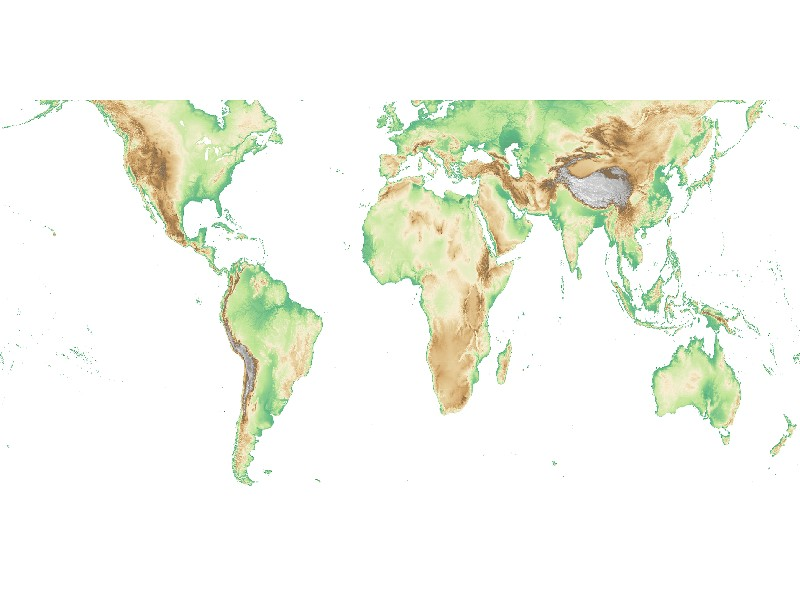

In [14]:
from IPython.display import Image
Image(filename=save_fp)


## Fetch from OGC API Features (WFS3)
Although this may sound very advanced, this is actually one of 
the simpler OGC APIs.


In [15]:

from owslib.wfs import WebFeatureService
w = WebFeatureService('https://demo.pygeoapi.io/master', version='3.0')


In [16]:
# Conformance stuff
print('This OGC API Features endpoint conforms to %s' % w.conformance())
api = w.api() # OpenAPI definition


This OGC API Features endpoint conforms to {'conformsTo': ['http://www.opengis.net/spec/wfs-1/3.0/req/core', 'http://www.opengis.net/spec/wfs-1/3.0/req/oas30', 'http://www.opengis.net/spec/wfs-1/3.0/req/html', 'http://www.opengis.net/spec/wfs-1/3.0/req/geojson']}


In [17]:
# Get collections (datasets) in endpoint
collections = w.collections()
print('This OGC API Features endpoint has %s datasets' % len(collections))


This OGC API Features endpoint has 13 datasets


In [18]:
# Get items (paged) in Lakes collection
lakes = w.collection('lakes')
lakes_query = w.collection_items('lakes')
lakes_query['features'][0]


{'type': 'Feature',
 'properties': {'id': 0,
  'scalerank': 0,
  'name': 'Lake Baikal',
  'name_alt': 'https://en.wikipedia.org/wiki/Lake_Baikal',
  'admin': None,
  'featureclass': 'Lake'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[106.57998579307912, 52.79998159444554],
    [106.53998823448521, 52.93999888774037],
    [107.0800069519353, 53.18001007751998],
    [107.2999935242018, 53.37999787048953],
    [107.59997521365611, 53.51998932556822],
    [108.03994835818912, 53.859968573616456],
    [108.37997928266967, 54.25999583598784],
    [109.05270307824526, 55.027597561251326],
    [109.19346967980832, 55.53560272889659],
    [109.50699059452313, 55.73091380474372],
    [109.92980716353523, 55.7129562445223],
    [109.70000206913326, 54.980003567110515],
    [109.66000451053935, 54.71999359803395],
    [109.47996382043448, 54.33999095317566],
    [109.31997358605884, 53.81999685323869],
    [109.22003136600637, 53.619983222052994],
    [108.99999311730755, 53.780025132860

## Searching for the data in CSW server

Here we will use a metadata service (CSW) to find our target 
data service, a regular WFS (v2).

### Step 1 - Find WFS endpoints by querying a CSW endpoint

First step: let's find some WFS service in our CSW server:
NOTE: You can skip this step and use the URL directly


In [ ]:
from owslib.fes import PropertyIsLike, BBox, And, PropertyIsEqualTo
from owslib.csw import CatalogueServiceWeb

thecsw = CatalogueServiceWeb('http://geoportal.gov.cz/php/micka/csw/index.php')


In [ ]:

# wfs_query = PropertyIsLike('csw:AnyText', 'WFS')
geology_query = PropertyIsLike('csw:AnyText', 'Geology')
service_query = PropertyIsLike('apiso:type', 'service')
geology_and_wfs = And([geology_query, service_query])
thecsw.getrecords2([geology_and_wfs], esn='full')

print(thecsw.results)


In [ ]:

for recid in thecsw.records:
    record = thecsw.records[recid]
    print(recid, record.title)

### Step 2 - Get the WFS endpoint and interact with it
Let's have a look at WFS data in czech Geology survey.

In [ ]:
geology = thecsw.records['575a4ef6-2f74-43ed-9352-6f400a010852']
print("Abstract:\n %s\n" % geology.abstract)

print("Identifier: %s" % geology.identifiers[1]['identifier'])


In [ ]:
from owslib import wfs as webfeatureservice
url = "http://inspire.geology.cz/geoserver/wms?service=WMS&version=1.3.0&request=Getcapabilities"
geology_wfs = webfeatureservice.WebFeatureService(geology.identifiers[1]['identifier'])



Service metadta (Capabilities):

In [ ]:
capabilities = geology_wfs.getcapabilities()
print("URL: %s" % capabilities.geturl())
print("Name: %s" % geology_wfs.provider.name)
print("Title: %s" % geology_wfs.identification.title)
print("Keywords: %s" % geology_wfs.identification.keywords[0])
print("Fees: %s" % geology_wfs.identification.fees)
print("Abstract: %s" % geology_wfs.identification.abstract)

Print list of available layers 

In [ ]:
for i in geology_wfs.contents:
    print("\n#### {} ####".format(i))
    print(geology_wfs.contents[i].abstract)

Download data from selected layer

In [ ]:
identifier = 'gsmlp:CZE_CGS_500k_Fault'
features = geology_wfs.getfeature([identifier])

# with open("test/geology_faults.gml", "w") as out:
#     out.write(features.read())



---
[<- Publishing](09-publishing.ipynb) | [Emerging technology and trends ->](11-emerging-technology-trends.ipynb)